# Investigating sensitivity to FWHM and amplitude of profile after low-/high-pass filtering

In [41]:
import sys
import os
sys.path.append('../../ThumbStack')
sys.path.append('../../LensQuEst')
import importlib

import flat_map
importlib.reload(flat_map)
from flat_map import *

import matplotlib.pyplot as plt
import cmasher as cm
plt.style.use('default.mplstyle')
%matplotlib inline

import numpy as np
import fitsio
import pixell
importlib.reload(pixell)
from functools import partial

In [3]:

def colorbar(mappable):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import matplotlib.pyplot as plt
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax)
    plt.sca(last_axes)
    return cbar

In [4]:
# some constants
rad2arcmin = 180. * 60. / np.pi
arcmin2rad = 1/rad2arcmin
peaktau = 2.45e-4
tau_fwhm = 5.
tau_sigma = 5 / np.sqrt(8*np.log(2))
gauss_norm = 2 * np.pi * tau_sigma**2

In [5]:
def make_basemap():
    # map dimensions in degrees
    sizeX = 10.
    sizeY = 10.
    
    # number of pixels for the flat map, let's do 0.5' pixels
    nX = int(sizeX*60.*2.)
    nY = int(sizeY*60.*2.)
    
    # basic map object
    baseMap = FlatMap(nX=nX, nY=nY, sizeX=sizeX*np.pi/180., sizeY=sizeY*np.pi/180.)

    # order: [[ra_min, dec_max], [ra_max, dec_min]]
    box = np.array([[10., 210.], [20., 200.]]) * utils.degree
    resArcmin = 0.5  # map pixel size [arcmin]
    shape,wcs = enmap.geometry(pos=box, res=resArcmin * utils.arcmin, proj='cea')
    
    # create a mask that keeps the whole area
    boxMask = enmap.ones(shape, wcs=wcs)
    # pixsizemap = boxMask.pixsizemap()
    return baseMap, boxMask, wcs

In [6]:
def make_stampmap():
    # map dimensions in degrees
    sizeX = 0.5084
    sizeY = 0.5084
    
    # number of pixels for the flat map, let's do 0.5' pixels
    nX = int(sizeX*60.*2.)
    nY = int(sizeY*60.*2.)
    
    # basic map object
    baseMap = FlatMap(nX=nX, nY=nY, sizeX=sizeX*np.pi/180., sizeY=sizeY*np.pi/180.)

    # single object's centroid
    centroid = [0,0]
    # order: [[ra_min, dec_max], [ra_max, dec_min]]
    box = np.array([[centroid[1]-sizeX/2, centroid[0]+sizeX/2], [centroid[1]+sizeX/2, centroid[0]-sizeX/2]]) * utils.degree
    resArcmin = 0.5  # map pixel size [arcmin]
    shape,wcs = enmap.geometry(pos=box, res=resArcmin * utils.arcmin, proj='cea')
    
    # create a mask that keeps the whole area
    boxMask = enmap.ones(shape, wcs=wcs)

    return baseMap, boxMask, wcs

In [7]:
def make_ptsrc_map(baseMap, plot=True):
    """make stamp with 1 Dirac function
    """
    stampcen_x, stampcen_y = 30, 30
    dmap = baseMap.copy()
    pixarea = (dmap.sizeX/np.pi*180.*60./dmap.nX)**2 #approx
    dmap.data[stampcen_y, stampcen_y] += 1/pixarea # to normalize map when multiplied by pixel area
    dmap.dataFourier = dmap.fourier()
    if plot:
        f = plt.figure()
        im = plt.imshow(dmap.data)
        colorbar(im)

    return dmap

In [8]:
def make_2ptsrc_map(baseMap, sep=0, plot=True):
    """make stamp with 2 Dirac functions separated by sep pixels
    sep: separation of the 2 centroids in pixels (i.e. [0.5arcmin])
    """
    stampcen_x, stampcen_y = 30, 30
    pt1_cen_x = int(np.floor(stampcen_x))
    pt2_cen_x = int(np.ceil(stampcen_x + sep))
    dmap = baseMap.copy()
    pixarea = (dmap.sizeX/np.pi*180.*60./dmap.nX)**2 #approx
    dmap.data[stampcen_y, pt1_cen_x] += 1./pixarea
    dmap.data[stampcen_y, pt2_cen_x] += 1./pixarea
    dmap.dataFourier = dmap.fourier()
    if plot:
        f = plt.figure()
        im = plt.imshow(dmap.data)
        colorbar(im)

    return dmap

In [9]:
def fbeam(ell, fwhm):
    # takes a fwhm in arcmin
    fwhm_rad = fwhm * np.pi / 180. / 60.
    sigma_rad = fwhm_rad / np.sqrt(8.*np.log(2.))

    return np.exp(-0.5*(ell * sigma_rad)**2)

In [10]:
def gaussify_map(baseMap, fwhm=5., plot=True):
    gaussfn = partial(fbeam, fwhm=fwhm)
    gmap = baseMap.copy()
    gmap.dataFourier = gmap.filterFourierIsotropic(fW=gaussfn)
    gmap.data = gmap.inverseFourier()
    if plot:
        f = plt.figure()
        im = plt.imshow(gmap.data)
        colorbar(im)

    return gmap

In [11]:
def renorm_map(baseMap, renorm=2.45e-4, profile_fwhm=5., plot=True):
    """normalize to peak value of `renorm`"""
    sigma = profile_fwhm / np.sqrt(8.*np.log(2.))
    gmap.data *= 2. * np.pi * sigma**2
    gmap.data *= renorm
    gmap.dataFourier = gmap.fourier()
    if plot:
        f = plt.figure()
        im = plt.imshow(gmap.data)
        colorbar(im)

    return gmap

In [12]:
def beam_map(baseMap, beam_fwhm=1.6, plot=True):
    beamfn = partial(fbeam, fwhm=beam_fwhm)
    beammap = baseMap.copy()
    beammap.dataFourier = beammap.filterFourierIsotropic(fW=beamfn)
    beammap.data = beammap.inverseFourier()
    if plot:
        f = plt.figure()
        im = plt.imshow(beammap.data)
        colorbar(im)

    return beammap

In [13]:
# Setup filtering
from scipy.special import erf

def hpf_theo(ell):
    loc = 1500
    half_width = 50

    return erf(2/np.sqrt(2)/half_width*(ell-loc))/2 + 0.5

def lpf_theo(ell):
    loc = 1000
    half_width = 50

    return -1 * erf(2/np.sqrt(2)/half_width*(ell-loc))/2 + 0.5

def hpf_will(ell):
    # do piecewise filtering
    low_ell = ell[ell<2350]
    mid_ell = ell[np.logical_and(2350<ell, ell<2500)]
    hi_ell = ell[ell>2500]
    low_filt = np.zeros_like(low_ell)
    mid_filt = np.sin((mid_ell-2350) * np.pi/300.)
    hi_filt = np.ones_like(hi_ell)
    tot_filt = np.concatenate([low_filt, mid_filt, hi_filt])
    
    return tot_filt

def lpf_will(ell):
    # do piecewise filtering
    low_ell = ell[ell<2000]
    mid_ell = ell[np.logical_and(2000<ell, ell<2150)]
    hi_ell = ell[ell>2150]
    low_filt = np.ones_like(low_ell)
    mid_filt = np.cos((mid_ell-2000) * np.pi/300.)
    hi_filt = np.zeros_like(hi_ell)
    tot_filt = np.concatenate([low_filt, mid_filt, hi_filt])

    return tot_filt

In [14]:
def make_filtered_enmap(flatmap, filt, wcs, plot=True):
    filt_map = flatmap.copy()
    filt_map.dataFourier = filt_map.filterFourierIsotropic(fW=filt)
    filt_map.data = filt_map.inverseFourier()
    filt_map.data = np.hstack([np.zeros((61,1)), filt_map.data]) # map loses a column during filtering
    filt_enmap = enmap.enmap(filt_map.data, wcs)
    if plot:
        f = plt.figure()
        im = plt.imshow(filt_map.data)
        colorbar(im)

    return filt_enmap

In [15]:
def calc_profile(filt_enmap, boxMask):
    # get ra, dec for each pixel to help with aperture filters
    opos = boxMask.posmap()
    dec = opos[0,:,:]
    ra = opos[1,:,:]
    radius = np.sqrt(ra**2 + dec**2)
    # exact angular area of a pixel [sr] (same for all pixels in CEA, not CAR)
    pixArea = ra.area() / len(ra.flatten())
    RAp = np.linspace(1., 6., 9) # aperture radii for radial profile
    rad2arcmin = 180. * 60. / np.pi
    ring_areas = []
    filt_profile = []
    for iRAp in range(9):
        if iRAp == 0:
            r0 = 0
        else:
            r0 = RAp[iRAp - 1] / 60. * np.pi / 180.
        r1 = RAp[iRAp] / 60. * np.pi / 180.
        inRing = 1.*(radius>=r0)*(radius<r1)
        # exact angular area of ring [sr]
        ringArea = np.sum(inRing) * pixArea
        ring_areas.append(ringArea * rad2arcmin**2) # get exact ring areas for making density profile
        filtMap = np.sum(pixArea * inRing * filt_enmap)
        filt_profile.append(filtMap)
    filt_dens_profile = np.array(filt_profile) * rad2arcmin**2 / ring_areas
    ring_areas = np.array(ring_areas)

    return RAp, filt_dens_profile, ring_areas

In [16]:
def plot_mean_tau(RAp, filt_dens_profile, ax=None, **kwargs):    
    if ax==None:
        f, ax = plt.subplots(1,1)
    ax.plot(RAp, filt_dens_profile, **kwargs)

In [17]:
fwhm = 5.
sigma = fwhm / np.sqrt(8.*np.log(2))
denorm = 2. * np.pi * sigma**2
pixarea = 0.25 # approx
peaktau = 2.45e-4

Text(0, 0.5, '$\\langle \\tau \\rangle$')

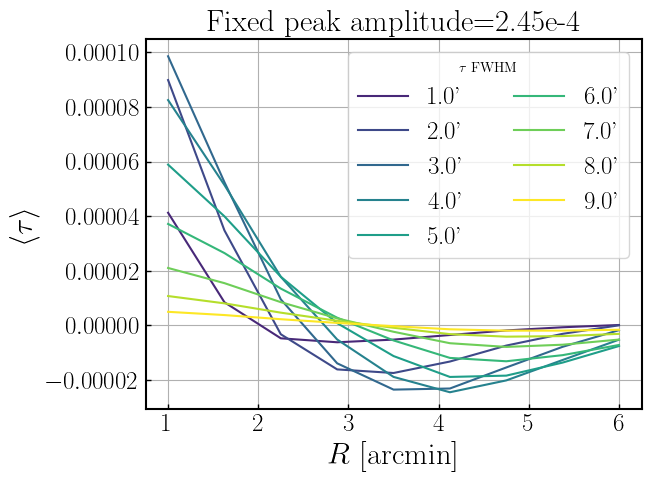

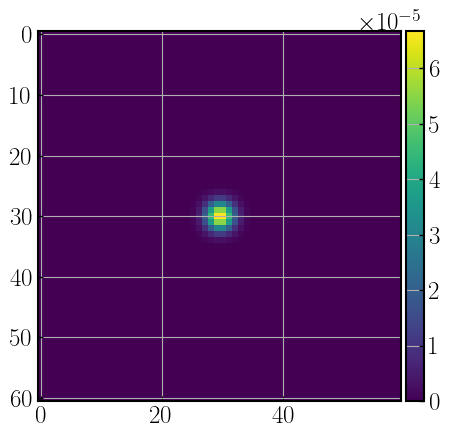

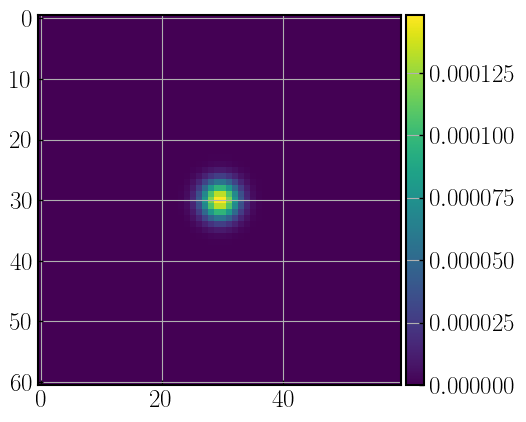

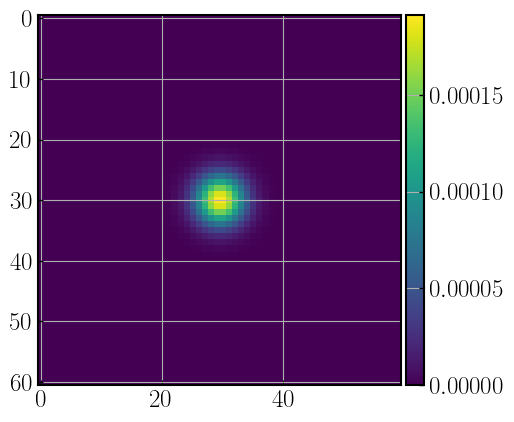

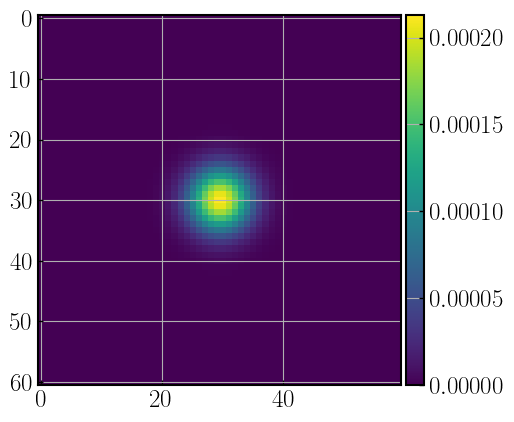

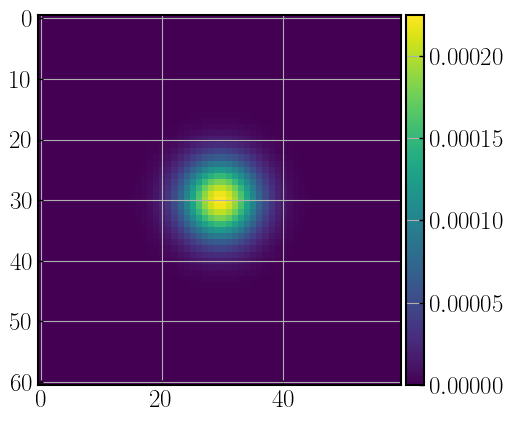

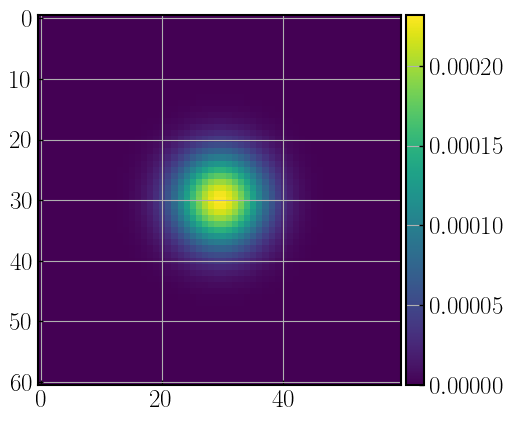

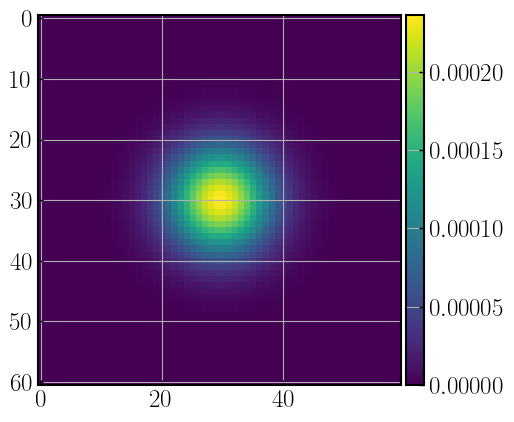

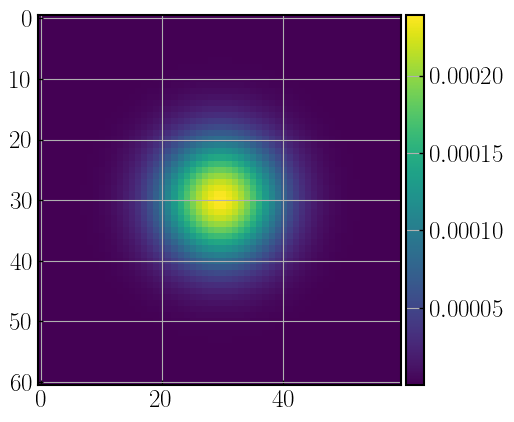

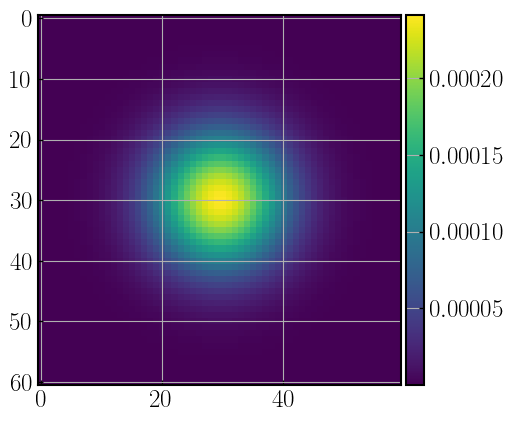

In [19]:
# make single object profile
fwhms = np.linspace(1,9,9)
f, ax = plt.subplots(1,1)
for fwhm in fwhms:
    baseMap, boxMask, wcs = make_stampmap()
    dmap = make_ptsrc_map(baseMap, plot=False)
    gmap = gaussify_map(dmap, fwhm=fwhm, plot=False)
    gmap = renorm_map(gmap, renorm=2.45e-4, profile_fwhm=fwhm, plot=False)
    gmap = beam_map(gmap)
    filt_enmap = make_filtered_enmap(gmap, hpf_will, wcs, plot=False)
    RAp, filt_one_profile, ring_areas = calc_profile(filt_enmap, boxMask)
    plot_mean_tau(RAp, filt_one_profile, ax=ax, c=plt.get_cmap('viridis')(fwhm/len(fwhms)), label=str(fwhm)+'\'')
ax.legend(ncol=2, title=r'$\tau$ FWHM')
ax.set_title('Fixed peak amplitude=2.45e-4')
ax.set_xlabel(r'$R$ [arcmin]')
ax.set_ylabel(r'$\langle \tau \rangle$')

0.03530169602442425
[0.00706034 0.01000296 0.01417202 0.02007867 0.0284471  0.04030334
 0.05710105 0.08089976 0.11461734 0.1623878 ]


Text(0, 0.5, '$\\langle \\tau \\rangle$')

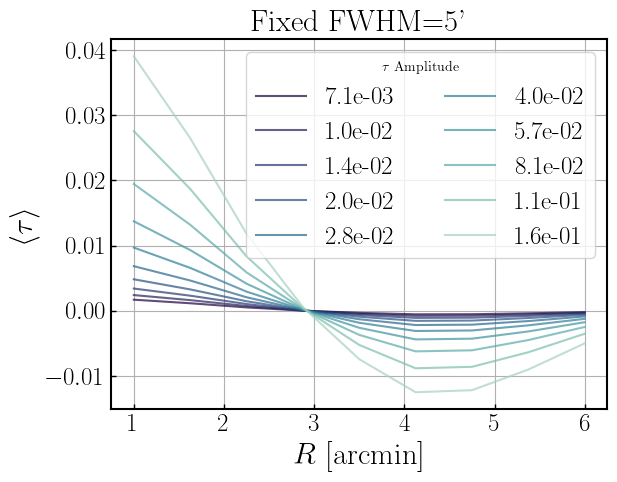

In [18]:
# make single object profile
norms = np.logspace(np.log10(1/denorm/5), np.log10(1/denorm*4.6), 10)
print(1/denorm)
print(norms)
colors = cm.take_cmap_colors('cmr.ocean', 10, cmap_range=(0, 0.8), return_fmt='hex')
f, ax = plt.subplots(1,1)
for i, norm in enumerate(norms):
    baseMap, boxMask, wcs = make_stampmap()
    dmap = make_ptsrc_map(baseMap, plot=False)
    gmap = gaussify_map(dmap, fwhm=5., plot=False)
    gmap = renorm_map(gmap, renorm=norm, profile_fwhm=5., plot=False)
    gmap = beam_map(gmap, plot=False)
    filt_enmap = make_filtered_enmap(gmap, hpf_will, wcs, plot=False)
    RAp, filt_one_profile, ring_areas = calc_profile(filt_enmap, boxMask)
    plot_mean_tau(RAp, filt_one_profile, ax=ax, c=colors[i], label='%.1e'%norm, alpha=0.7)
ax.legend(ncol=2, title=r'$\tau$ Amplitude')
ax.set_title('Fixed FWHM=5\'')
ax.set_xlabel(r'$R$ [arcmin]')
ax.set_ylabel(r'$\langle \tau \rangle$')
# plt.savefig('/home/theo/Documents/research/CMB/patchy_tau_sims/paper_figures/fixed_tau_fwhm.pdf', dpi=300, bbox_inches='tight')

0.03530169602442425
[0.00706034 0.01000296 0.01417202 0.02007867 0.0284471  0.04030334
 0.05710105 0.08089976 0.11461734 0.1623878 ]


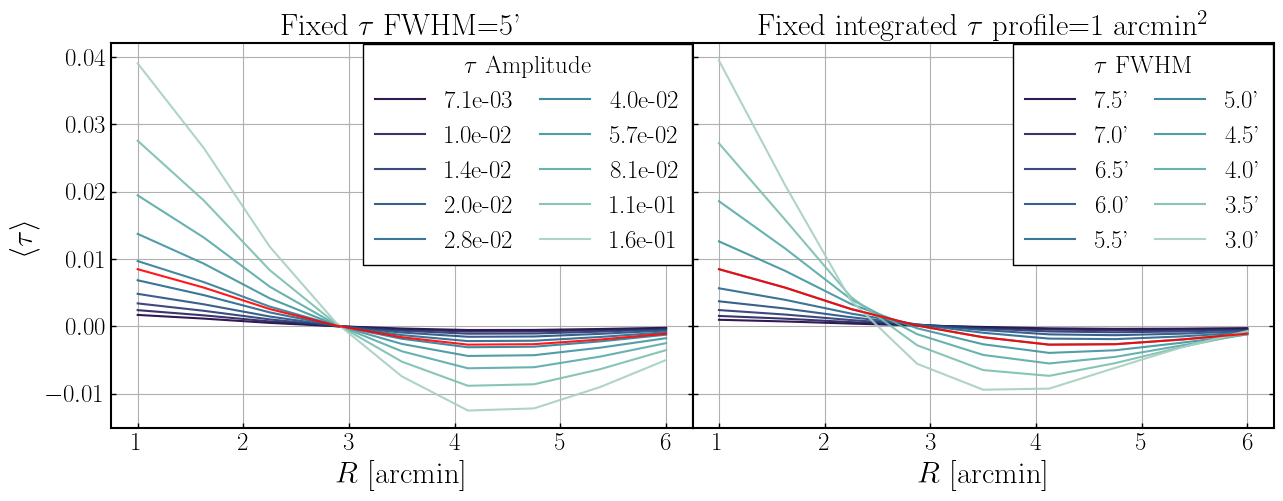

In [110]:
# make single object profile
colors = cm.take_cmap_colors('cmr.ocean', 10, cmap_range=(0, 0.8), return_fmt='hex')
f, axs = plt.subplots(1,2, figsize=(15,5), sharey=True)

norms = np.logspace(np.log10(1/denorm/5), np.log10(1/denorm*4.6), 10)
print(1/denorm)
print(norms)
baseMap, boxMask, wcs = make_stampmap()
dmap = make_ptsrc_map(baseMap, plot=False)
for i, norm in enumerate(norms):
    gmap = gaussify_map(dmap, fwhm=5., plot=False)
    gmap = renorm_map(gmap, renorm=norm, profile_fwhm=5., plot=False)
    gmap = beam_map(gmap, plot=False)
    filt_enmap = make_filtered_enmap(gmap, hpf_will, wcs, plot=False)
    RAp, filt_one_profile, ring_areas = calc_profile(filt_enmap, boxMask)
    plot_mean_tau(RAp, filt_one_profile, ax=axs[0], c=colors[i], label='%.1e'%norm, alpha=0.9)

axs[0].legend(ncol=2, title=r'$\tau$ Amplitude', borderaxespad=0.02, borderpad=0.5, framealpha=1., 
              fancybox=False, edgecolor='k', columnspacing=1.)
axs[0].yaxis.set_ticks_position('both')
axs[0].set_title(r"Fixed $\tau$ FWHM=5'")
axs[0].set_xlabel(r'$R$ [arcmin]')
axs[0].set_ylabel(r'$\langle \tau \rangle$')


fwhms = np.linspace(3,7.5,10)
for i, fwhm in enumerate(fwhms[::-1]):
    gmap = gaussify_map(dmap, fwhm=fwhm, plot=False)
    gmap = beam_map(gmap, plot=False)
    filt_enmap = make_filtered_enmap(gmap, hpf_will, wcs, plot=False)
    RAp, filt_one_profile, ring_areas = calc_profile(filt_enmap, boxMask)
    plot_mean_tau(RAp, filt_one_profile, ax=axs[1], c=colors[i], label=str(fwhm)+'\'', alpha=0.9)
# plot comparison profile
gmap = gaussify_map(dmap, fwhm=5., plot=False)
gmap = beam_map(gmap, plot=False)
filt_enmap = make_filtered_enmap(gmap, hpf_will, wcs, plot=False)
RAp, filt_one_profile, ring_areas = calc_profile(filt_enmap, boxMask)
plot_mean_tau(RAp, filt_one_profile, ax=axs[0], c='red', alpha=0.9)
plot_mean_tau(RAp, filt_one_profile, ax=axs[1], c='red', alpha=0.9)
axs[1].legend(ncol=2, title=r'$\tau$ FWHM', borderaxespad=0.02, borderpad=0.5, framealpha=1.,
              fancybox=False, edgecolor='k', columnspacing=1.)
# axs[1].legend(ncol=2, title=r'$\tau$ FWHM', frameon=False)
axs[1].yaxis.set_ticks_position('both')
axs[1].set_title(r'Fixed integrated $\tau$ profile=1 arcmin$^2$')
axs[1].set_xlabel(r'$R$ [arcmin]')
plt.subplots_adjust(wspace=0.)
# axs[1].set_ylabel(r'$\langle \tau \rangle$')
# plt.savefig('/home/theo/Documents/research/CMB/patchy_tau_sims/paper_figures/fixed_tau_fwhm.pdf', dpi=300, bbox_inches='tight')

plt.savefig('/home/theo/Documents/research/CMB/patchy_tau_sims/paper_figures/fixed_tau_integral+fwhm_horizontal.pdf', dpi=300, bbox_inches='tight')

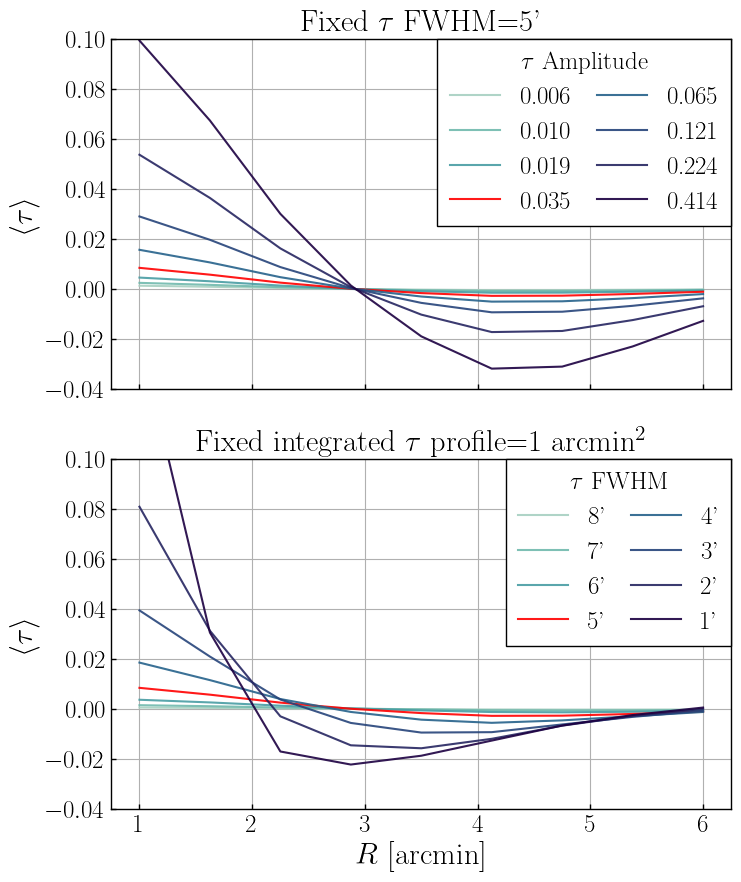

In [43]:
# make single object profile
baseMap, boxMask, wcs = make_stampmap()
dmap = make_ptsrc_map(baseMap, plot=False)
colors[::-1] = cm.take_cmap_colors('cmr.ocean', 8, cmap_range=(0, 0.8), return_fmt='hex')
f, axs = plt.subplots(2,1, figsize=(8,10), sharex=True)

ymin = -0.04
ymax = 0.1
nticks = 8
spacing = 1.85
norms = np.logspace(np.log10((1/denorm)*spacing**(-3)), np.log10((1/denorm)*spacing**4), 8)
for i, norm in enumerate(norms):
    gmap = gaussify_map(dmap, fwhm=5., plot=False)
    gmap = renorm_map(gmap, renorm=norm, profile_fwhm=5., plot=False)
    gmap = beam_map(gmap, plot=False)
    filt_enmap = make_filtered_enmap(gmap, hpf_will, wcs, plot=False)
    RAp, filt_one_profile, ring_areas = calc_profile(filt_enmap, boxMask)
    if not i == 3:
        color = colors[i]
    else:
        color = 'r'
    plot_mean_tau(RAp, filt_one_profile, ax=axs[0], c=color, label='%.3f'%norm, alpha=0.9)

l = axs[0].legend(ncol=2, title=r'$\tau$ Amplitude', borderaxespad=0., borderpad=0.5, framealpha=1., 
              fancybox=False, edgecolor='k', columnspacing=1., title_fontsize=18)
l.get_frame().set_linewidth(1.)
# axs[0].yaxis.set_ticks_position('both')
axs[0].set_title(r"Fixed $\tau$ FWHM=5'")
# axs[0].set_xlabel(r'$R$ [arcmin]')
axs[0].set_ylabel(r'$\langle \tau \rangle$')
axs[0].set_ylim(ymin, ymax)
axs[0].set_yticks(np.linspace(ymin, ymax, nticks))

fwhms = np.linspace(1,8,8)
for i, fwhm in enumerate(fwhms[::-1]):
    gmap = gaussify_map(dmap, fwhm=fwhm, plot=False)
    gmap = beam_map(gmap, plot=False)
    filt_enmap = make_filtered_enmap(gmap, hpf_will, wcs, plot=False)
    RAp, filt_one_profile, ring_areas = calc_profile(filt_enmap, boxMask)
    if not i == 3:
        color = colors[i]
    else:
        color = 'r'
    plot_mean_tau(RAp, filt_one_profile, ax=axs[1], c=color, label='%i\''%fwhm, alpha=0.9)
# plot comparison profile
gmap = gaussify_map(dmap, fwhm=5., plot=False)
gmap = beam_map(gmap, plot=False)
filt_enmap = make_filtered_enmap(gmap, hpf_will, wcs, plot=False)
RAp, filt_one_profile, ring_areas = calc_profile(filt_enmap, boxMask)
# plot_mean_tau(RAp, filt_one_profile, ax=axs[0], c='red', alpha=0.9)
# plot_mean_tau(RAp, filt_one_profile, ax=axs[1], c='red', alpha=0.9)
l = axs[1].legend(ncol=2, title=r'$\tau$ FWHM', borderaxespad=0., borderpad=0.5, framealpha=1.,
              fancybox=False, edgecolor='k', columnspacing=1., title_fontsize=18)
l.get_frame().set_linewidth(1.)
# axs[1].legend(ncol=2, title=r'$\tau$ FWHM', frameon=False)
# axs[1].yaxis.set_ticks_position('both')
axs[1].set_title(r'Fixed integrated $\tau$ profile=1 arcmin$^2$')
axs[1].set_ylabel(r'$\langle \tau \rangle$')
axs[1].set_xlabel(r'$R$ [arcmin]')
axs[1].set_ylim(ymin, ymax)
axs[1].set_yticks(np.linspace(ymin, ymax, nticks))

plt.subplots_adjust(hspace=0.2)

# axs[1].set_ylabel(r'$\langle \tau \rangle$')
# plt.savefig('/home/theo/Documents/research/CMB/patchy_tau_sims/paper_figures/fixed_tau_fwhm.pdf', dpi=300, bbox_inches='tight')

plt.savefig('/home/theo/Documents/research/CMB/patchy_tau_sims/paper_figures/fixed_tau_integral+fwhm_vertical_v2.pdf', dpi=300, bbox_inches='tight')